In [1]:
import os
import glob
import numpy as np
from warnings import simplefilter
import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import string
from nltk.stem import WordNetLemmatizer 
import random
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

simplefilter(action='ignore', category=FutureWarning)

train_positive_path = '../Sentiment_Analysis/aclImdb/train/pos/'
train_negative_path = '../Sentiment_Analysis/aclImdb/train/neg/'
test_positive_path = '../Sentiment_Analysis/aclImdb/test/pos/'
test_negative_path = '../Sentiment_Analysis/aclImdb/test/neg/'

def read_files_in_path(path):
    positive_training_data=[]
    for filepath in glob.glob(os.path.join(path, '*.txt')):
        with open(filepath,encoding='utf8') as f:
            content = f.read()
            positive_training_data.append(content)
    return positive_training_data

#Read training data
positive_training_data = read_files_in_path(train_positive_path)
negative_training_data = read_files_in_path(train_negative_path)
whole_training_data = positive_training_data+negative_training_data

#Reading Test Data
positive_test_data = read_files_in_path(test_positive_path)
negative_test_data = read_files_in_path(test_negative_path)
whole_test_data = positive_test_data+negative_test_data


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MohamedTourab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MohamedTourab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MohamedTourab\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#Remove HTML tags from dataset
def cleanhtml(whole_training_data):
    no_HTML_whole_training_data = []
    cleaner = re.compile('<.*?>')
    for review in whole_training_data:
        cleantext = re.sub(cleaner, '', review)
        no_HTML_whole_training_data.append(cleantext)
    return no_HTML_whole_training_data

#Remove stop words, punctuation and Lemmatize words
def remove_punc_stop_words(no_HTML_whole_training_data):
    clean_training_data = []
    for review in no_HTML_whole_training_data:
        #remove punctuation marks
        review = review.lower()
        for ch in string.punctuation:
            review = review.replace(ch,' ')
        #Remove stop words
        stop_words = set(stopwords.words('english')) 
        word_tokens = word_tokenize(review) 
        filtered_words = [w for w in word_tokens if not w in stop_words] 
        #construct the review again
        sentence =''
        for word in filtered_words:
            sentence+=lemmatize_word(word)
            sentence+=' '
        clean_training_data.append(sentence)
    return clean_training_data


def lemmatize_word(word):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word)


#clean data from HTML tags
no_HTML_whole_training_data = cleanhtml(whole_training_data)
# print(whole_training_data[210])
# print('\n',no_HTML_whole_training_data[210])

clean_training_data = remove_punc_stop_words(no_HTML_whole_training_data)
# print(set(stopwords.words('english')))
# print('\n',no_HTML_whole_training_data[210])
# print('\n',clean_training_data[210])
# print('\n',no_HTML_whole_training_data[310])
# print('\n',clean_training_data[310])
# print('\n',no_HTML_whole_training_data[4510])
# print('\n',clean_training_data[4510])
no_HTML_whole_test_data = cleanhtml(whole_test_data)
clean_test_data = remove_punc_stop_words(no_HTML_whole_test_data)

In [3]:
#create labels for the training data and test data first 12500 are positive and the remaining 12500 are negative
train_labels = np.asarray([1]*len(positive_training_data) + [0]*len(negative_training_data))
test_labels = np.asarray([1]*len(positive_test_data) + [0]*len(negative_test_data))

#randomize test data
z = list(zip(clean_training_data, train_labels))
random.shuffle(z)
random_clean_training_data, random_train_labels = zip(*z)

#Apply feature extraction: Term Frequency inverse document frequency vectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,2))
train_vector = vectorizer.fit_transform(random_clean_training_data)
test_vector = vectorizer.transform(clean_test_data)
#printing some visualization of the sizes of the train and test vectors 
#print(train_labels.shape)
#train_vector has 25000 row corresponding to the 25000 review and 74849 feature extracted
#print(train_vector.shape)

#print shapes of test vector and label

# print(test_labels.shape)
# print(test_vector.shape)

#some visualization for th labels arrays
# print(random_train_labels)
# print(test_labels)

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
import pandas as pd

clf = GridSearchCV(linear_model.LogisticRegression(),{'C':[0.1,1,10,50,100,1000]},cv=5,return_train_score=False)
clf.fit(train_vector, random_train_labels)
df=pd.DataFrame(clf.cv_results_)
print(df[['param_C','mean_test_score']])

  param_C  mean_test_score
0     0.1          0.84052
1       1          0.87868
2      10          0.89168
3      50          0.89472
4     100          0.89504
5    1000          0.89572


In [9]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
clf = linear_model.LogisticRegression(C=100)
scores = cross_val_score(clf, train_vector, random_train_labels, cv=5)
print(scores*100)
print("Mean Accuracy: %0.2f  (+/- %0.2f deviation) " % (scores.mean()*100, scores.std()))

[89.72 89.42 88.5  90.18 89.7 ]
Mean Accuracy: 89.50  (+/- 0.01 deviation) 


In [10]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=100)
logreg.fit(train_vector, random_train_labels)
print("Logistic Regression classification accuracy:\n",logreg.score(test_vector,test_labels)*100,"%")


Logistic Regression classification accuracy:
 88.276 %


In [11]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[11045  1455]
 [ 1476 11024]]


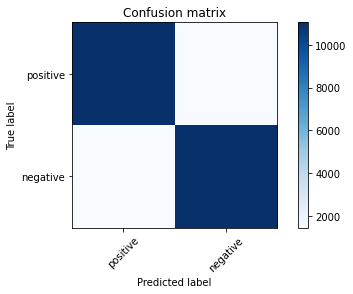

In [12]:
from sklearn.metrics import confusion_matrix
test_predicted=logreg.predict(test_vector)
cm=confusion_matrix(test_labels, test_predicted)
plot_confusion_matrix(cm, labels=["positive","negative"])
print(cm)